# Fine tuning Longformer

In [ ]:
import jsonlines
import torch
import torch.nn as nn
import numpy as np
from transformers import LongformerModel, LongformerTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset, load_from_disk
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sentence_transformers import SentenceTransformer, util
import os
import hashlib
import nltk
from nltk.tokenize import sent_tokenize
import evaluate
from collections import defaultdict

# Download NLTK punkt tokenizer
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

def nltk_sent_tokenize(text):
    """Splits text into sentences using NLTK."""
    return sent_tokenize(text)

def get_token_f1_score(candidate_tokens, reference_tokens):
    """Computes a token-based F1 score between a candidate and reference sentence."""
    candidate_tokens_set = set(candidate_tokens)
    reference_tokens_set = set(reference_tokens)
    if not candidate_tokens_set or not reference_tokens_set:
        return 0.0
    intersection = len(candidate_tokens_set.intersection(reference_tokens_set))
    precision = intersection / len(candidate_tokens_set)
    recall = intersection / len(reference_tokens_set)
    if precision + recall == 0:
        return 0.0
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

# ==============================================================================
# 1. Custom Model Definition for Longformer
# ==============================================================================
class LongformerExtractiveSummarizationModel(nn.Module):
    """A custom PyTorch model for extractive summarization using a Longformer backbone."""
    def __init__(self, pos_weight=None):
        super(LongformerExtractiveSummarizationModel, self).__init__()
        self.longformer = LongformerModel.from_pretrained('allenai/longformer-base-4096')
        self.dropout = nn.Dropout(p=0.1)
        self.classifier = nn.Linear(self.longformer.config.hidden_size, 1)
        self.pos_weight = pos_weight if pos_weight is not None else torch.tensor(1.0)

    def forward(self, input_ids=None, attention_mask=None, global_attention_mask=None, labels=None):
        outputs = self.longformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            global_attention_mask=global_attention_mask
        )
        sequence_output = outputs.last_hidden_state
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)
        logits = logits.squeeze(-1)
        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(logits.device))
            loss = loss_fct(logits, labels.float())
        return (loss, logits) if loss is not None else logits

# ==============================================================================
# 2. Configuration and Data Loading
# ==============================================================================
DATA_DIR = "govreport_tfidf_vscode2"
NUM_TRAIN_SAMPLES = 5000
NUM_VAL_SAMPLES = 300
NUM_TEST_SAMPLES = 300
F1_THRESHOLD = 0.3
CACHE_DIR = "dataset_cache_longformer_v4"
CHUNK_SIZE = 4096
train_file = f"{DATA_DIR}/train.json"
test_file = f"{DATA_DIR}/test.json"
validation_file = f"{DATA_DIR}/validation.json"

def load_jsonl_data(file_path, max_samples=None):
    """Loads a JSON Lines file and returns a list of dictionaries."""
    data = []
    with jsonlines.open(file_path) as reader:
        for i, obj in enumerate(reader):
            if max_samples and i >= max_samples:
                break
            data.append(obj)
    return data

print(f"Loading {NUM_TRAIN_SAMPLES} samples from the training file...")
train_data_raw = load_jsonl_data(train_file, max_samples=NUM_TRAIN_SAMPLES)
print(f"Loading {NUM_VAL_SAMPLES} samples from the validation file...")
validation_data_raw = load_jsonl_data(validation_file, max_samples=NUM_VAL_SAMPLES)

# ==============================================================================
# 3. Data Preprocessing and Dataset Creation
# ==============================================================================
def preprocess_data(data):
    """Processes raw data, validates inputs, and precomputes sentence embeddings."""
    sent_model = SentenceTransformer('all-MiniLM-L6-v2')
    processed_samples = []
    for i, item in enumerate(data):
        original_text = item.get('original_text', '')
        extractive_summary = item.get('extractive_summary', '')
        if not isinstance(original_text, str) or not original_text.strip():
            continue
        if not isinstance(extractive_summary, str) or not extractive_summary.strip():
            continue
        document_sentences = nltk_sent_tokenize(original_text)
        sentence_embeddings = sent_model.encode(document_sentences, convert_to_numpy=True).tolist()
        processed_samples.append({
            'document': original_text,
            'extractive_summary': extractive_summary,
            'id': i,
            'document_sentences': document_sentences,
            'sentence_embeddings': sentence_embeddings
        })
    print(f"Processed {len(processed_samples)} valid samples out of {len(data)}")
    return processed_samples

train_data = preprocess_data(train_data_raw)
validation_data = preprocess_data(validation_data_raw)

# ==============================================================================
# 4. Tokenizer, Label Alignment, and Caching
# ==============================================================================
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

def tokenize_and_align_labels(examples, f1_threshold=F1_THRESHOLD):
    """Tokenizes documents without truncation, creates hierarchical chunks, and aligns labels."""
    all_input_ids = []
    all_attention_mask = []
    all_global_attention_mask = []
    all_labels = []
    all_document_id = []
  
    for idx, (doc, summary, doc_id, doc_sentences) in enumerate(zip(
        examples['document'], examples['extractive_summary'], examples['id'], examples['document_sentences']
    )):
        print(f"Processing document {idx} (ID: {doc_id})...")
        if not doc or not summary:
            continue
      
        summary_sentences = nltk_sent_tokenize(summary)
        if not doc_sentences or not summary_sentences:
            continue
      
        tokenized_summary_sentences = [tokenizer.tokenize(s) for s in summary_sentences]
        sentence_labels = []
        tokenized_doc_sentences = []
        for doc_sentence in doc_sentences:
            doc_sent_tokens = tokenizer.tokenize(doc_sentence)
            tokenized_doc_sentences.append(tokenizer.encode(doc_sentence, add_special_tokens=False))
            max_f1 = max(get_token_f1_score(doc_sent_tokens, sum_sent_tokens) for sum_sent_tokens in tokenized_summary_sentences) if tokenized_summary_sentences else 0.0
            sentence_labels.append(1.0 if max_f1 >= f1_threshold else 0.0)
      
        current_input_ids = [tokenizer.cls_token_id]
        current_attention_mask = [1]
        current_labels = [0.0]
        current_sent_idx = 0
      
        while current_sent_idx < len(doc_sentences):
            while current_sent_idx < len(doc_sentences):
                sent_tokens = tokenized_doc_sentences[current_sent_idx]
                if len(current_input_ids) + len(sent_tokens) + 1 > CHUNK_SIZE:
                    break
                current_input_ids += sent_tokens
                current_attention_mask += [1] * len(sent_tokens)
                current_labels += [sentence_labels[current_sent_idx]] * len(sent_tokens)
                current_sent_idx += 1
            
            if len(current_input_ids) > 1:
                current_input_ids.append(tokenizer.sep_token_id)
                current_attention_mask.append(1)
                current_labels.append(0.0)
                
                padding_length = CHUNK_SIZE - len(current_input_ids)
                if padding_length > 0:
                    current_input_ids += [tokenizer.pad_token_id] * padding_length
                    current_attention_mask += [0] * padding_length
                    current_labels += [0.0] * padding_length
                
                global_attention_mask = [0] * len(current_input_ids)
                global_attention_mask[0] = 1
                
                all_input_ids.append(current_input_ids)
                all_attention_mask.append(current_attention_mask)
                all_global_attention_mask.append(global_attention_mask)
                all_labels.append(current_labels)
                all_document_id.append(doc_id)
            
            if current_sent_idx < len(doc_sentences):
                current_input_ids = [tokenizer.cls_token_id]
                current_attention_mask = [1]
                current_labels = [0.0]
      
        if not all_input_ids or len(all_input_ids[-1]) < 10:
            continue
  
    return {
        'input_ids': all_input_ids,
        'attention_mask': all_attention_mask,
        'global_attention_mask': all_global_attention_mask,
        'labels': all_labels,
        'document_id': all_document_id
    }

def load_or_generate_dataset(data, split_name, max_samples, f1_threshold=F1_THRESHOLD):
    """Loads a cached dataset or generates and caches a new one."""
    if not data:
        print(f"No valid data for {split_name} after preprocessing")
        return Dataset.from_dict({'input_ids': [], 'attention_mask': [], 'global_attention_mask': [], 'labels': [], 'document_id': []})
  
    cache_key = f"{split_name}-{max_samples}-{f1_threshold}"
    cache_path = os.path.join(CACHE_DIR, hashlib.md5(cache_key.encode()).hexdigest())
    if os.path.exists(cache_path):
        print(f"Loading cached dataset from {cache_path}...")
        return load_from_disk(cache_path)
  
    print(f"Generating and caching dataset for {split_name} at {cache_path}...")
    dataset = Dataset.from_dict({
        'document': [item['document'] for item in data],
        'extractive_summary': [item['extractive_summary'] for item in data],
        'id': [item['id'] for item in data],
        'document_sentences': [item['document_sentences'] for item in data],
        'sentence_embeddings': [item['sentence_embeddings'] for item in data]
    })
    dataset_tokenized = dataset.map(
        lambda examples: tokenize_and_align_labels(examples, f1_threshold),
        batched=True,
        batch_size=4,
        remove_columns=["document", "extractive_summary", "id", "document_sentences", "sentence_embeddings"],
        desc=f"Tokenizing {split_name} data",
        num_proc=4
    )
  
    def is_valid_example(example):
        if not isinstance(example['input_ids'], list) or not example['input_ids']:
            return False
        if len(example['input_ids']) != len(example['attention_mask']) or \
           len(example['input_ids']) != len(example['global_attention_mask']) or \
           len(example['input_ids']) != len(example['labels']):
            return False
        if 'document_id' not in example:
            return False
        return True
  
    dataset_tokenized = dataset_tokenized.filter(is_valid_example, desc=f"Filtering invalid examples for {split_name}")
  
    if not os.path.exists(CACHE_DIR):
        os.makedirs(CACHE_DIR)
  
    dataset_tokenized.save_to_disk(cache_path)
    print("Caching complete.")
    return dataset_tokenized

# Clear cache to ensure new tokenization
"""if os.path.exists(CACHE_DIR):
    import shutil
    shutil.rmtree(CACHE_DIR)"""

train_dataset_tokenized = load_or_generate_dataset(train_data, 'train', NUM_TRAIN_SAMPLES)
validation_dataset_tokenized = load_or_generate_dataset(validation_data, 'validation', NUM_VAL_SAMPLES)

print(f"Train dataset size: {len(train_dataset_tokenized)}")
print(f"Validation dataset size: {len(validation_dataset_tokenized)}")

if len(train_dataset_tokenized) == 0 or len(validation_dataset_tokenized) == 0:
    raise ValueError("One or both datasets are empty after processing.")

# Calculate pos_weight based on class imbalance
def calculate_pos_weight(dataset):
    """Calculates pos_weight based on the ratio of negative to positive labels."""
    pos_count = 0
    neg_count = 0
    for example in dataset:
        labels = example['labels']
        pos_count += sum(1 for label in labels if label == 1.0)
        neg_count += sum(1 for label in labels if label == 0.0)
    pos_weight = neg_count / pos_count if pos_count > 0 else 1.0
    return torch.tensor(pos_weight)

pos_weight = calculate_pos_weight(train_dataset_tokenized)
print(f"Calculated pos_weight: {pos_weight.item():.2f}")

# Calculate average reference summary length for dynamic top_k
def calculate_avg_summary_sentences(data):
    """Calculates the average number of sentences in reference summaries."""
    total_sentences = sum(len(nltk_sent_tokenize(item['extractive_summary'])) for item in data)
    return max(1, round(total_sentences / len(data)))

avg_summary_sentences = calculate_avg_summary_sentences(validation_data)
print(f"Average reference summary sentences: {avg_summary_sentences}")

# ==============================================================================
# 5. Custom metrics for evaluation with ROUGE, Top-k, and MMR
# ==============================================================================
rouge_metric = evaluate.load("rouge")

def compute_metrics(eval_pred, raw_data, tokenizer_obj, eval_dataset, top_k=avg_summary_sentences, lambda_mmr=1):
    logits, labels = eval_pred
    predictions = torch.sigmoid(torch.from_numpy(logits))
    predictions_binary = (predictions > 0.5).numpy().astype(int)
    
    labels_flat = labels.flatten()
    predictions_flat = predictions_binary.flatten()
    
    metrics = {}
    if len(labels_flat) > 0:
        metrics["f1"] = f1_score(labels_flat, predictions_flat, average='binary', zero_division=0)
        metrics["precision"] = precision_score(labels_flat, predictions_flat, average='binary', zero_division=0)
        metrics["recall"] = recall_score(labels_flat, predictions_flat, average='binary', zero_division=0)
        metrics["accuracy"] = accuracy_score(labels_flat, predictions_flat)
    else:
        metrics["f1"] = 0.0
        metrics["precision"] = 0.0
        metrics["recall"] = 0.0
        metrics["accuracy"] = 0.0
    
    predicted_summaries = []
    reference_summaries = []
    
    doc_logits = defaultdict(list)
    doc_attention = defaultdict(list)
    for i, doc_id in enumerate(eval_dataset['document_id']):
        doc_logits[doc_id].append(predictions[i].numpy())
        doc_attention[doc_id].append(eval_dataset['attention_mask'][i])
    
    for doc_id in sorted(doc_logits.keys()):
        chunks = doc_logits[doc_id]
        att_masks = doc_attention[doc_id]
        reference_summaries.append(raw_data[doc_id]['extractive_summary'])
        document = raw_data[doc_id]['document']
        sentence_embeddings = np.array(raw_data[doc_id]['sentence_embeddings'])
        
        aggregated_scores = []
        for chunk, att_mask in zip(chunks, att_masks):
            effective_len = sum(att_mask)
            if effective_len < 3:
                continue
            content_scores = chunk[1:effective_len - 1]
            aggregated_scores.extend(content_scores)
        
        document_sentences = nltk_sent_tokenize(document)
        sentence_scores = []
        tokenized_doc_sentences = [tokenizer_obj.encode(s, add_special_tokens=False) for s in document_sentences]
        
        start_index = 0
        for sent_tokens in tokenized_doc_sentences:
            end_index = start_index + len(sent_tokens)
            if end_index > len(aggregated_scores):
                break
            sentence_logits = aggregated_scores[start_index:end_index]
            sentence_scores.append(np.max(sentence_logits) if len(sentence_logits) > 0 else 0.0)
            start_index = end_index
        
        sentence_embeddings = torch.tensor(sentence_embeddings, dtype=torch.float32)
        selected_indices = []
        for _ in range(min(top_k, len(document_sentences))):
            if not sentence_scores:
                break
            if not selected_indices:
                best_idx = np.argmax(sentence_scores)
                selected_indices.append(best_idx)
            else:
                mmr_scores = []
                for i, score in enumerate(sentence_scores):
                    if i in selected_indices:
                        mmr_scores.append(-float('inf'))
                        continue
                    relevance = score
                    max_similarity = max([util.pytorch_cos_sim(sentence_embeddings[i], sentence_embeddings[j]).item() for j in selected_indices])
                    mmr_score = lambda_mmr * relevance - (1 - lambda_mmr) * max_similarity
                    mmr_scores.append(mmr_score)
                best_idx = np.argmax(mmr_scores)
                if mmr_scores[best_idx] > 0:
                    selected_indices.append(best_idx)
        
        predicted_sentences = [document_sentences[i] for i in selected_indices]
        if not predicted_sentences and document_sentences:
            predicted_sentences.append(document_sentences[0])
        
        predicted_summaries.append(" ".join(predicted_sentences))
    
    rouge_results = rouge_metric.compute(predictions=predicted_summaries, references=reference_summaries, use_stemmer=True)
    
    rouge1_val = rouge_results["rouge1"]
    rouge2_val = rouge_results["rouge2"]
    rougeL_val = rouge_results["rougeL"]
    metrics.update({
        "rouge1": rouge1_val.mid.fmeasure if hasattr(rouge1_val, 'mid') else rouge1_val,
        "rouge2": rouge2_val.mid.fmeasure if hasattr(rouge2_val, 'mid') else rouge2_val,
        "rougeL": rougeL_val.mid.fmeasure if hasattr(rougeL_val, 'mid') else rougeL_val,
    })
    
    return metrics

# ==============================================================================
# 6. Training Arguments and Trainer
# ==============================================================================
total_train_batch_size = 4 * 2
approx_num_chunks = sum(1 for _ in train_dataset_tokenized) if train_dataset_tokenized else 5000
max_steps = (approx_num_chunks // total_train_batch_size) * 5
save_steps = max(500, max_steps // 10)

training_args = TrainingArguments(
    output_dir="./extractive_summarization_results",
    eval_strategy="steps",
    eval_steps=save_steps,
    save_strategy="steps",
    save_steps=save_steps,
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    max_steps=max_steps,
    gradient_accumulation_steps=2,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=100,
)

# Find the latest checkpoint
latest_checkpoint = None
if os.path.exists(training_args.output_dir):
    checkpoints = [d for d in os.listdir(training_args.output_dir) if d.startswith("checkpoint-")]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=lambda x: int(x.split("-")[1]))
        latest_checkpoint = os.path.join(training_args.output_dir, latest_checkpoint)

model = LongformerExtractiveSummarizationModel(pos_weight=pos_weight)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_tokenized,
    eval_dataset=validation_dataset_tokenized,
    compute_metrics=lambda p: compute_metrics(p, validation_data, tokenizer, validation_dataset_tokenized, top_k=avg_summary_sentences, lambda_mmr=1),
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# ==============================================================================
# 7. Start the fine-tuning
# ==============================================================================
print("Starting training...")
trainer.train(resume_from_checkpoint=latest_checkpoint)
print("Training finished.")

## Results

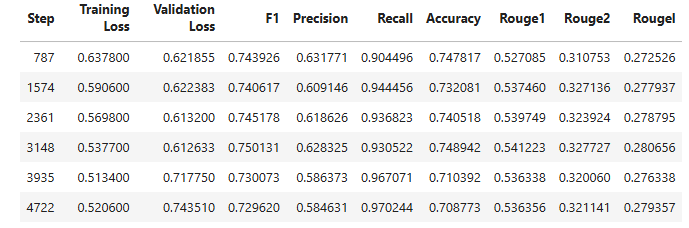